In [1]:
import numpy as np 
import glob
import os 
import matplotlib.pyplot as plt

vol_lst= glob.glob("/content/drive/MyDrive/Seg3D/KiTS2019/kits19/output/vol/*")
msk_lst= glob.glob("/content/drive/MyDrive/Seg3D/KiTS2019/kits19/output/seg/*")


In [2]:
idc = np.random.choice(len(vol_lst))
print("idc:", idc)

random_vol = np.load(vol_lst[idc])
print(np.unique(random_vol))
print(random_vol.shape)

random_msk = np.load(msk_lst[idc])
print("\n", np.unique(random_msk))
print(random_msk.shape)


idc: 5
[-198.09832495 -196.8022712  -189.74009726 ...  393.06820583  395.15051799
  396.69774079]
(139, 256, 256)

 [0. 1. 2.]
(139, 256, 256)


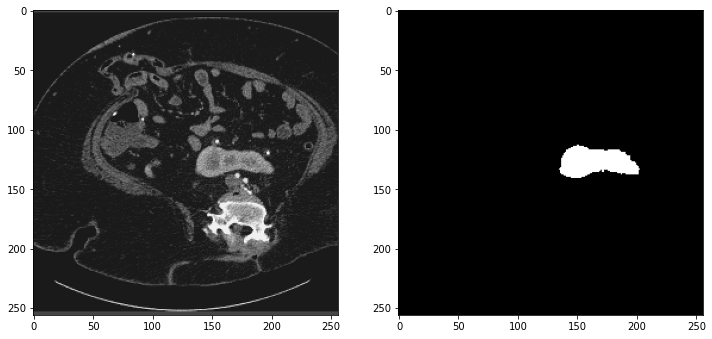

In [3]:
_, axes = plt.subplots(1, 2, figsize=(12, 8))
axes[0].imshow(random_vol[random_vol.shape[0]//2], cmap=plt.cm.gray)
axes[1].imshow(random_msk[random_msk.shape[0]//2], cmap=plt.cm.gray)
plt.show()